## 0. Drive 연결 및 압축 해제

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content
!unzip -qq "/content/drive/MyDrive/크몽/EEG_Analysis.zip"

/content


## 1. 사용할 패키지 불러오기

In [1]:
import cv2
from librosa.feature import melspectrogram
import librosa
import numpy as np
from scipy import io
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import timm


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/jongwook95.lee/miniforge3/envs/cnn_based_audio_classification/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터 셋 구성

In [2]:
data_dir = "content/ica_filtered_data"

data_list = os.listdir(data_dir)
features = []
labels = []
for data in data_list:
  labels.append(data.split('_')[0])
  data_path = os.path.join(data_dir, data)
  data = io.loadmat(data_path)
  features.append(data['Clean_data'])

features = np.stack(features)

In [3]:
def mel_spectrogram(signal, sr, img_height, img_width):
    """Generate melody spectrogram with targeted size

    Parameters
    -----------
    signal : np.array
        1 dimensional (N,) signal
    sr : int
        sampling rate of signal
    img_height : int 
        target image height
    img_width : int 
        target image width

    Returns
    -------
    np.array
        melspectrogram. with shape of 2 dimensional numpy array
        (img_height, img_width)
    """
    
    hop_length = len(signal) // img_width
    n_fft = hop_length * 4 
    spec=melspectrogram(y=signal, sr=sr, n_fft=n_fft,
                        hop_length=hop_length, n_mels=224)
    spec= librosa.power_to_db(S=spec, ref=np.max)
    spec = spec[ :, :img_width]
    spec=cv2.resize(spec,[img_height, img_width])
    return spec

In [4]:
def standarize(img):
    """Normalize a Single Image by Gaussian Distribution (mean, std).

    Parameters
    -----------
    img : np.array
        a single image np array with channel last (C x H x W) 
    Returns
    -------
    np.array
        standarized image
    """
    img = (img - np.mean(img, axis=(1,2))[:, np.newaxis, np.newaxis]) / \
        np.std(img, axis=(1,2))[:, np.newaxis, np.newaxis]
    return img

In [5]:
spectrograms  =[]

for i in range(features.shape[0]):
    spec = np.zeros((32,224,224))
    for channel in range(features.shape[1]):
        sensor = features[i, channel, :]
        spec[channel, :, :] = mel_spectrogram(sensor, 128, 224, 224)


    spec = standarize(spec)
    spectrograms.append(spec)
        

spectrograms = np.stack(spectrograms)
print("Spectrograms Shape: {}".format(spectrograms.shape))

/home/jongwook95.lee/miniforge3/envs/cnn_based_audio_classification/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


Spectrograms Shape: (480, 32, 224, 224)


In [6]:
ohe = OneHotEncoder(sparse=False)
labels = ohe.fit_transform(np.array(labels).reshape(-1,1))

/home/jongwook95.lee/miniforge3/envs/cnn_based_audio_classification/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
train_X, test_X, train_y, test_y = train_test_split(spectrograms, labels, test_size = 0.2, random_state = 101, stratify = labels)

## 3. DataLoader 생성

In [9]:
from torch.utils.data import Dataset
class LoadDataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, X, y):
        super(LoadDataset, self).__init__()

        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).float()

    def __getitem__(self, index):
        return self.x_data[index, :, :, :], self.y_data[index, :]

    def __len__(self):
        return self.len


def data_generator_np(train_X, train_y, test_X, test_y, batch_size):
    train_dataset = LoadDataset(train_X, train_y)
    test_dataset = LoadDataset(test_X, test_y)

    # to calculate the ratio for the CAL
    all_ys = np.concatenate((train_dataset.y_data, test_dataset.y_data))
    all_ys = all_ys.tolist()
    num_classes = len(np.unique(all_ys))
    counts = [all_ys.count(i) for i in range(num_classes)]

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=False,
                                               num_workers=0)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=False,
                                              num_workers=0)

    return train_loader, test_loader, counts

### Data Loader 생성 (pytorch 특성상 input을 Data loader로 받음)
train_data_loader, valid_data_loader, data_count = data_generator_np(train_X, train_y, test_X, test_y, 16)



## 4. Mobilenet V2 CNN Network

In [10]:
LEARNING_RATE = 0.0001
EPOCHS = 50

### (1) Build Model

In [10]:
class mobilenet_v2_Network(nn.Module):
    def __init__(self,num_classes=4, pretrained = True):
        super().__init__()
        self.first_conv = nn.Conv2d(32, 3, (1,1), 1, 1) # you could use e.g. a 1x1 kernel
        self.model = models.mobilenet_v2(pretrained=pretrained)
        # Change the output layer to output classes instead of 1000 classes
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        out = self.first_conv(x)
        out = self.model(out)
        return out

In [14]:
model = mobilenet_v2_Network(num_classes = 4, pretrained = True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### (2) Training

In [20]:
result_path = './Baseline_model'
if not os.path.exists(result_path):
    os.makedirs(result_path)


max_valid_acc = 0

for e in range(EPOCHS):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()     # Optional when not using Model Specific layer
    for X,y in train_data_loader:
        if torch.cuda.is_available():
            X, y = X.float().to(device), y.float().to(device)

        optimizer.zero_grad()
        target = model(X)
        loss = loss_fn(target,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = torch.argmax(target, dim=1)
        correct += (predicted == torch.argmax(y, dim=1)).float().sum()
        total += y.shape[0]

    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for X,y in valid_data_loader:
        if torch.cuda.is_available():
            X, y = X.float().to(device), y.float().to(device)


        target = model(X)
        loss = loss_fn(target,y)
        valid_loss += loss.item()
        _, predicted = torch.max(target, 1)
        predicted = torch.argmax(y, dim=1)
        correct += (predicted == torch.argmax(target, dim=1)).float().sum()
        total += y.shape[0]
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_data_loader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(valid_data_loader)} \t Validation Acc: {valid_acc}')
    if valid_acc > max_valid_acc:
        print(f'Validation Acc Increased({max_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        max_valid_acc = valid_acc
        # Saving State Dict
        torch.save(model.state_dict(), result_path + '/Best_MobileNet_model.pth')

Epoch 1 	 Training Loss: 1.4185127814610798 	 Training Acc: 0.2682291865348816 		 Validation Loss: 1.458113193511963 	 Validation Acc: 0.2604166865348816
Validation Acc Increased(0.000000--->0.260417) 	 Saving The Model
Epoch 2 	 Training Loss: 1.1610791981220245 	 Training Acc: 0.578125 		 Validation Loss: 1.5417290528615315 	 Validation Acc: 0.2395833432674408
Epoch 3 	 Training Loss: 0.9037063419818878 	 Training Acc: 0.7890625 		 Validation Loss: 1.4898662964502971 	 Validation Acc: 0.2708333432674408
Validation Acc Increased(0.260417--->0.270833) 	 Saving The Model
Epoch 4 	 Training Loss: 0.582268754641215 	 Training Acc: 0.9244791865348816 		 Validation Loss: 1.659391164779663 	 Validation Acc: 0.2916666865348816
Validation Acc Increased(0.270833--->0.291667) 	 Saving The Model
Epoch 5 	 Training Loss: 0.2545911855995655 	 Training Acc: 0.9895833730697632 		 Validation Loss: 1.7164531548817952 	 Validation Acc: 0.2916666865348816
Epoch 6 	 Training Loss: 0.09597575136770804 	 Tr

### (3) Inference

In [21]:
model.load_state_dict(torch.load("./Baseline_model/Best_MobileNet_model.pth"))

<All keys matched successfully>

[[10  4  7  3]
 [ 6  6  5  7]
 [ 2  4  8 10]
 [ 8  5  2  9]]
              precision    recall  f1-score   support

           0       0.38      0.42      0.40        24
           1       0.32      0.25      0.28        24
           2       0.36      0.33      0.35        24
           3       0.31      0.38      0.34        24

    accuracy                           0.34        96
   macro avg       0.34      0.34      0.34        96
weighted avg       0.34      0.34      0.34        96



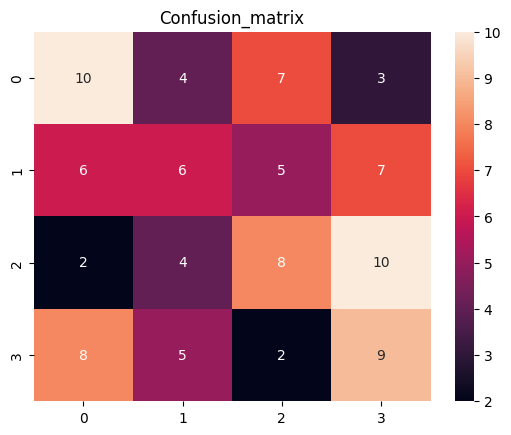

In [22]:
preds = []
gt = []

for X,y in valid_data_loader:
    if torch.cuda.is_available():
        X, y = X.float().cuda(), y.float().cuda()


    target = model(X)

    predicted = torch.argmax(target, dim=1)
    true_y = torch.argmax(y, dim=1)
    preds = preds + list(predicted.cpu().numpy())
    gt = gt + list(true_y.cpu().numpy())




distribution = confusion_matrix(gt, preds)
plt.figure()
ax = sns.heatmap(distribution, annot=True,fmt='g')
plt.title('Confusion_matrix')
plt.savefig(os.path.join(result_path, 'Confusion_matrix.png'))
print(distribution)
print(classification_report(gt, preds))

## 5. Vision Transformer CNN Network

### (1) Build Model

In [11]:
class vit_Network(nn.Module):
    def __init__(self,num_classes=4, pretrained = True):
        super().__init__()
        self.first_conv = nn.Conv2d(32, 3, (1,1), 1, 0) # you could use e.g. a 1x1 kernel
        self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
        
    def forward(self, x):
        out = self.first_conv(x)
        out = self.model(out)
        return out

In [12]:
model = vit_Network(num_classes = 4, pretrained = True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### (2) Training

In [14]:
result_path = './Baseline_model'
if not os.path.exists(result_path):
    os.makedirs(result_path)


max_valid_acc = 0

for e in range(EPOCHS):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()     # Optional when not using Model Specific layer
    for X,y in train_data_loader:
        if torch.cuda.is_available():
            X, y = X.float().to(device), y.float().to(device)

        optimizer.zero_grad()
        target = model(X)
        loss = loss_fn(target,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = torch.argmax(target, dim=1)
        correct += (predicted == torch.argmax(y, dim=1)).float().sum()
        total += y.shape[0]

    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for X,y in valid_data_loader:
        if torch.cuda.is_available():
            X, y = X.float().to(device), y.float().to(device)


        target = model(X)
        loss = loss_fn(target,y)
        valid_loss += loss.item()
        _, predicted = torch.max(target, 1)
        predicted = torch.argmax(y, dim=1)
        correct += (predicted == torch.argmax(target, dim=1)).float().sum()
        total += y.shape[0]
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_data_loader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(valid_data_loader)} \t Validation Acc: {valid_acc}')
    if valid_acc > max_valid_acc:
        print(f'Validation Acc Increased({max_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        max_valid_acc = valid_acc
        # Saving State Dict
        torch.save(model.state_dict(), result_path + '/Best_VIT_model.pth')

Epoch 1 	 Training Loss: 2.1354168901840844 	 Training Acc: 0.2369791716337204 		 Validation Loss: 1.6066639026006062 	 Validation Acc: 0.25
Validation Acc Increased(0.000000--->0.250000) 	 Saving The Model
Epoch 2 	 Training Loss: 1.5017837981383007 	 Training Acc: 0.2890625 		 Validation Loss: 1.4956611196200054 	 Validation Acc: 0.25
Epoch 3 	 Training Loss: 1.5004891206820805 	 Training Acc: 0.2630208432674408 		 Validation Loss: 1.549332082271576 	 Validation Acc: 0.25
Epoch 4 	 Training Loss: 1.4674286246299744 	 Training Acc: 0.2630208432674408 		 Validation Loss: 1.4029238025347393 	 Validation Acc: 0.25
Epoch 5 	 Training Loss: 1.478813459475835 	 Training Acc: 0.2578125 		 Validation Loss: 1.5500517288843791 	 Validation Acc: 0.25
Epoch 6 	 Training Loss: 1.4880303889513016 	 Training Acc: 0.2421875 		 Validation Loss: 1.5297085444132488 	 Validation Acc: 0.25
Epoch 7 	 Training Loss: 1.4791057407855988 	 Training Acc: 0.2421875 		 Validation Loss: 1.4245121081670125 	 Valida

### (3) Inference

In [15]:
model.load_state_dict(torch.load("./Baseline_model/Best_VIT_model.pth"))

<All keys matched successfully>

[[ 2 10  2 10]
 [ 1 17  4  2]
 [ 1 14  3  6]
 [ 4  8  4  8]]
              precision    recall  f1-score   support

           0       0.25      0.08      0.12        24
           1       0.35      0.71      0.47        24
           2       0.23      0.12      0.16        24
           3       0.31      0.33      0.32        24

    accuracy                           0.31        96
   macro avg       0.28      0.31      0.27        96
weighted avg       0.28      0.31      0.27        96



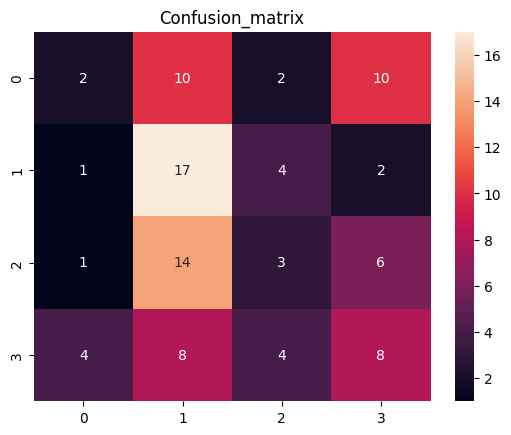

In [16]:
preds = []
gt = []

for X,y in valid_data_loader:
    if torch.cuda.is_available():
        X, y = X.float().cuda(), y.float().cuda()


    target = model(X)

    predicted = torch.argmax(target, dim=1)
    true_y = torch.argmax(y, dim=1)
    preds = preds + list(predicted.cpu().numpy())
    gt = gt + list(true_y.cpu().numpy())




distribution = confusion_matrix(gt, preds)
plt.figure()
ax = sns.heatmap(distribution, annot=True,fmt='g')
plt.title('Confusion_matrix')
plt.savefig(os.path.join(result_path, 'Confusion_matrix.png'))
print(distribution)
print(classification_report(gt, preds))